
This script performs statistical analysis on the star latent space
to complement the visual plots. It includes K-Means clustering to
formally identify groups of stars and a correlation analysis to
quantify the relationship between latent dimensions and physical properties.

In [8]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

color_map = {'O': '#8bd1ff', # Blue 8bd1ff
             'B': '#a7caff', # Blue-white
             'A': '#dae9ff', # White
             'F': '#fff7e8', # White-yellow
             'G': '#ffe9b5', # Yellow
             'K': '#ffcd89', # Orange
             'M': '#ffa77d', # Red
             'D': '#ffffff', # Dark Gray - White Dwarf
             'N': '#a52a2a', # Auburn - Cool Carbon Star
             'C': '#800000', # Maroon - Carbon Star
             'R': '#cd5c5c', # Indian Red - Hot Carbon Star
             'P': '#7fffd4', # Aquamarine - Planetary Nebulae
             'S': '#ffd700', # Gold - S-Type Star
             'W': '#fd3db5'} # Magenta - Wolf Rayet

def get_spectral_ordinal(spect):
    """
    Converts a spectral type string to an ordinal numerical value.
    This helps in understanding the relationship between the latent space
    and the spectral class.

    Args:
        spect (str): The spectral type string (e.g., 'G2V').

    Returns:
        int: An integer representing the spectral type.
    """
    if pd.isna(spect) or not spect:
        return np.nan

    spectral_map = {'W': 0, 'O': 1, 'B': 2, 'A': 3, 'F': 4, 'G': 5, 'K': 6,
                    'M': 7, 'S': 8, 'R': 9, 'C': 10, 'N': 11, 'D': 12, 'P': 13}

    # Return the mapped value for the primary spectral class
    return spectral_map.get(spect[0].upper(), np.nan)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
def assemble_dataset(latent_file_path='stars_data_1.csv.gz', hyg_file_path='hyg_v42.csv.gz', output_file_path='combined_stars.csv'):
    """
    Assembles a new dataset by combining latent coordinates with original
    high-quality star properties from the HYG data set.

    Args:
        latent_file_path (str): Path to the CSV file containing latent coordinates.
        hyg_file_path (str): Path to the gzipped HYG database file.
        output_file_path (str): Path to save the new, combined CSV file.
    """
    try:
        # Load the original HYG data (gzipped)
        hyg_df = pd.read_csv(hyg_file_path, compression='gzip')
        print(f"Loaded {len(hyg_df)} stars from HYG database.")
    except FileNotFoundError:
        print(f"Error: HYG database file not found at '{hyg_file_path}'.")
        print("Please ensure you have downloaded the compressed file.")
        return
    except Exception as e:
        print(f"Error loading HYG file: {e}")
        return

    try:
        # Load the latent space data
        latent_df = pd.read_csv(latent_file_path, compression='gzip')
        print(f"Loaded {len(latent_df)} stars from latent space data file.")
    except FileNotFoundError:
        print(f"Error: Latent data file not found at '{latent_file_path}'.")
        return

    # --- Step 1: Prepare the datasets for merging ---
    # Select only the essential columns from the HYG data
    hyg_subset_df = hyg_df[['id', 'ci', 'spect']]

    # --- Step 2: Merge the two dataframes ---
    # Use a left merge to keep all the stars from the latent dataset
    # and add the matching properties from the HYG database.
    combined_df = pd.merge(latent_df, hyg_subset_df, on='id', how='left', suffixes=('_latent', '_hyg'))

    print(f"Successfully merged dataframes. The combined dataset has {len(combined_df)} rows.")
    print('\n~~~~~~~~~~~~~~~Raw Merged Head and Tail~~~~~~~~~~~~~~~\n')
    print(combined_df.head())
    print(combined_df.tail())

    # --- Step 3: Clean up and select final columns ---
    # We now have duplicate spectral columns, so let's choose the high-quality one.
    if 'spect_hyg' in combined_df.columns:
        combined_df.drop('spect_hyg', axis=1, inplace=True)
        combined_df.rename(columns={'spect_latent': 'spect'}, inplace=True)

    # Reorder the columns to be more logical
    final_columns = ['id', 'latent_x', 'latent_y', 'latent_z',
                     'x', 'y', 'z', 'absmag', 'spect', 'ci']

    final_df = combined_df[final_columns]
    print('\n~~~~~~~~~~~~~~~Final Combined Head and Tail~~~~~~~~~~~~~~~\n')
    print(final_df.head())
    print(final_df.tail())

    # --- Prepare data for correlation and clustering ---
    # Add a new column for the ordinal spectral type
    final_df['spect_ordinal'] = final_df['spect'].apply(lambda x: get_spectral_ordinal(x))
    print('\n~~~~~~~~~~~~~~~Final Combined Head and Tail With Ordinal~~~~~~~~~~~~~~~\n')
    print(final_df.head())
    print(final_df.tail())

    # --- Step 4: Save the new dataset ---
    final_df.to_csv(output_file_path, index=False)
    print(f"\nNew dataset successfully saved to '{output_file_path}'.")
    print("\nColumns in the new dataset:")
    print(final_df.columns.tolist())

# Example usage of the function
if __name__ == "__main__":
    # You will need to make sure 'hyg_v42.csv.gz' is in the same directory,
    # or specify the correct path to it.
    assemble_dataset()

Loaded 119626 stars from HYG database.
Loaded 115368 stars from latent space data file.
Successfully merged dataframes. The combined dataset has 115368 rows.

~~~~~~~~~~~~~~~Raw Merged Head and Tail~~~~~~~~~~~~~~~

   id  latent_x  latent_y  latent_z         x       y         z  absmag  \
0   0    4.5361    1.9918    8.0927    0.0000  0.0000    0.0000   4.850   
1   1   12.6574    7.2655   31.1496  219.7405  0.0034    4.1771   2.390   
2   2    1.4037    1.9688    2.3019   45.2109  0.0034  -16.0090   5.866   
3   3   69.8413   25.0415  122.9406  344.5528  0.0302  277.6150  -1.619   
4   4   19.1469    2.6294   30.8915   82.8355  0.0125 -105.6195   2.421   

  spect_latent     ci spect_hyg  
0           G2  0.656       G2V  
1           F5  0.482        F5  
2           K3  0.999       K3V  
3           B9 -0.019        B9  
4           F0  0.370       F0V  
            id  latent_x  latent_y  latent_z        x        y        z  \
115363  119613    0.9080    1.2867    0.6360  13.3058  


Running K-Means for 1 to 20 clusters...
Elbow method plot saved to '/content/drive/MyDrive/Plots/elbow_method_plot_1.png'


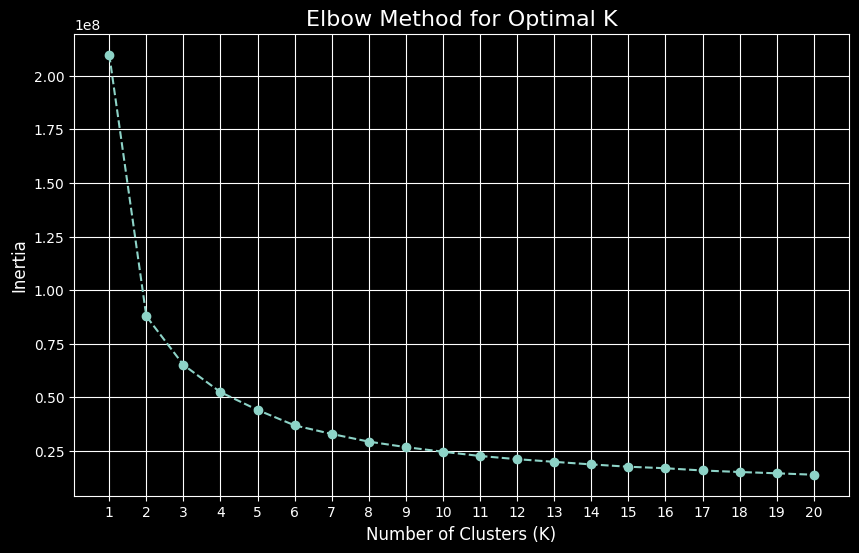

In [10]:
def find_optimal_clusters(file_path='combined_stars.csv', max_clusters=20):
    """
    Plots the inertia for K-Means to help find the optimal number of clusters
    using the Elbow Method.

    Args:
        file_path (str): Path to the combined CSV file.
        max_clusters (int): The maximum number of clusters to test.
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return

    X = df[['latent_x', 'latent_y', 'latent_z']]
    inertia = []

    print(f"\nRunning K-Means for 1 to {max_clusters} clusters...")
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), inertia, marker='o', linestyle='--')
    plt.title('Elbow Method for Optimal K', fontsize=16)
    plt.xlabel('Number of Clusters (K)', fontsize=12)
    plt.ylabel('Inertia', fontsize=12)
    plt.grid(True)
    plt.xticks(np.arange(1, max_clusters + 1, 1))
    plt.savefig('/content/drive/MyDrive/Plots/elbow_method_plot_1.png')
    print("Elbow method plot saved to '/content/drive/MyDrive/Plots/elbow_method_plot_1.png'")
    plt.show()

find_optimal_clusters()

--- Starting K-Means Clustering Analysis ---
K-Means clustering completed. Plotting the results.


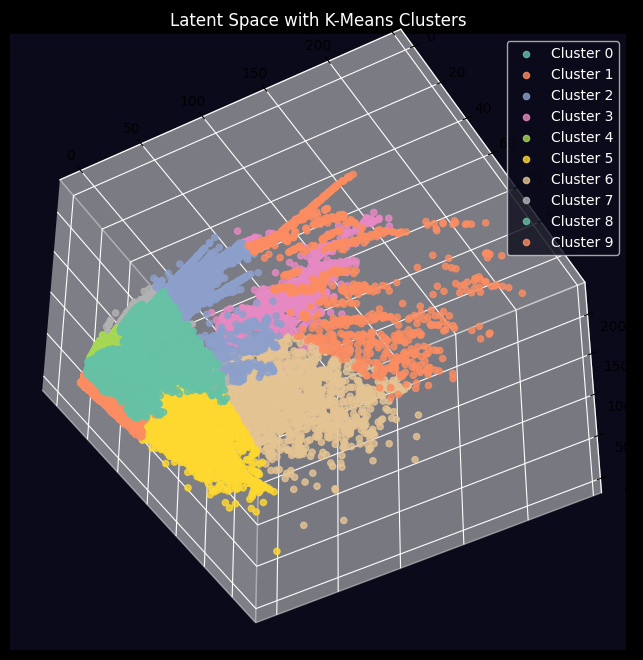

K-Means cluster plot saved to '/content/drive/MyDrive/Plots/kmeans_clusters_1.png'

--- Starting Correlation Analysis ---
Pearson Correlation Matrix:
               latent_x  latent_y  latent_z    absmag        ci  spect_ordinal
latent_x       1.000000  0.465973  0.754113 -0.425972 -0.627279      -0.698606
latent_y       0.465973  1.000000  0.426433 -0.892214  0.042577      -0.097240
latent_z       0.754113  0.426433  1.000000 -0.369750 -0.650448      -0.684251
absmag        -0.425972 -0.892214 -0.369750  1.000000 -0.059703       0.107964
ci            -0.627279  0.042577 -0.650448 -0.059703  1.000000       0.879553
spect_ordinal -0.698606 -0.097240 -0.684251  0.107964  0.879553       1.000000


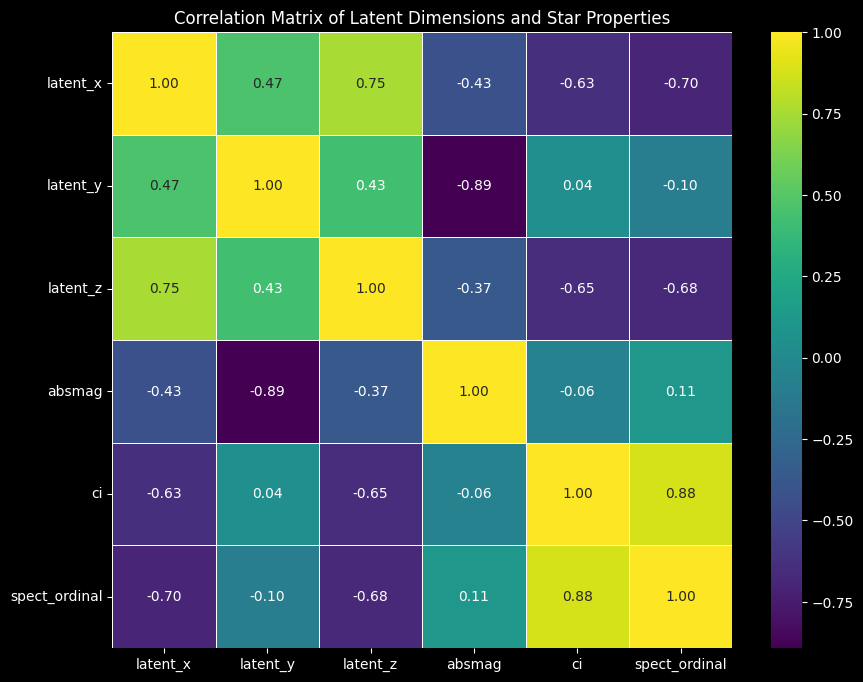

Correlation heatmap plot saved to '/content/drive/MyDrive/Plots/correlation_heatmap_1.png'


In [16]:
def perform_statistical_analysis(file_path='combined_stars.csv'):
    """
    Loads star data, performs K-Means clustering, and then runs a correlation analysis.

    Args:
        file_path (str): The path to the star data CSV file.
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return

    # Assuming the following columns exist based on the user's need to compare to a H-R diagram.
    # If not, you would need to add them to your dataset.
    required_columns = ['latent_x', 'latent_y', 'latent_z', 'absmag', 'spect', 'ci', 'spect_ordinal']
    if not all(col in df.columns for col in required_columns):
        print("Error: The CSV file must contain 'latent_x', 'latent_y', 'latent_z', 'absmag', 'spect', 'ci', 'spect_ordinal'.")
        return

    # --- Part 1: K-Means Clustering ---
    print("--- Starting K-Means Clustering Analysis ---")

    # We will cluster based on the latent space dimensions.
    X = df[['latent_x', 'latent_y', 'latent_z']]

    kmeans = KMeans(n_clusters=11, random_state=42, n_init=10)
    df['cluster_label'] = kmeans.fit_predict(X)

    print("K-Means clustering completed. Plotting the results.")

    plt.style.use('dark_background')
    fig = plt.figure(figsize=(12, 8), facecolor='black')
    ax = fig.add_subplot(111, projection='3d')
    ax.set_facecolor('#0a0a1a')

    # Plot each cluster with a unique color
    colors = sns.color_palette("Set2", n_colors=10)
    for i, color in enumerate(colors):
        cluster_df = df[df['cluster_label'] == i]
        ax.scatter(
            cluster_df['latent_x'],
            cluster_df['latent_y'],
            cluster_df['latent_z'],
            c=[color],
            alpha=0.8,
            s=20,
            label=f'Cluster {i}'
        )

    #ax.set_xlabel('Latent X', color='white')
    #ax.set_ylabel('Latent Y', color='white')
    #ax.set_zlabel('Latent Z', color='white')
    ax.set_title('Latent Space with K-Means Clusters', color='white')
    ax.tick_params(colors='black')
    ax.legend(facecolor='#0a0a1a', labelcolor='white')
    ax.view_init(elev=-45)
    plt.show()
    plt.savefig('/content/drive/MyDrive/Plots/kmeans_clusters_1.png', bbox_inches='tight', dpi=300)
    plt.close()
    print("K-Means cluster plot saved to '/content/drive/MyDrive/Plots/kmeans_clusters_1.png'")

    # --- Part 2: Correlation Analysis ---
    print("\n--- Starting Correlation Analysis ---")

    # Select the columns for correlation. We want to see how latent dimensions
    # correlate with physical properties.
    correlation_columns = ['latent_x', 'latent_y', 'latent_z', 'absmag', 'ci', 'spect_ordinal']
    correlation_df = df[correlation_columns]

    # Calculate the Pearson correlation matrix
    correlation_matrix = correlation_df.corr(method='pearson')

    print("Pearson Correlation Matrix:")
    print(correlation_matrix)

    # Visualize the correlation matrix as a heatmap for easier interpretation.
    plt.style.use('dark_background')
    plt.figure(figsize=(10, 8), facecolor='black')
    sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Latent Dimensions and Star Properties', color='white')
    plt.xticks(color='white')
    plt.yticks(color='white', rotation=0)
    plt.show()
    plt.savefig('/content/drive/MyDrive/Plots/correlation_heatmap_1.png', bbox_inches='tight', dpi=300)
    plt.close()
    print("Correlation heatmap plot saved to '/content/drive/MyDrive/Plots/correlation_heatmap_1.png'")

if __name__ == "__main__":
    perform_statistical_analysis()